
🚀 เริ่มการเทรน SAC-v1 และ SAC-v2

Ep 1/150 | SAC-v1: -1320.34 | SAC-v2: -1714.26
Ep 2/150 | SAC-v1: -1222.74 | SAC-v2: -1636.01
Ep 3/150 | SAC-v1: -1228.71 | SAC-v2: -1041.96
Ep 4/150 | SAC-v1: -1008.69 | SAC-v2: -1274.17
Ep 5/150 | SAC-v1: -1247.35 | SAC-v2: -1438.03
Ep 6/150 | SAC-v1: -1211.23 | SAC-v2: -1290.95
Ep 7/150 | SAC-v1: -1675.89 | SAC-v2: -1068.35
Ep 8/150 | SAC-v1: -1555.08 | SAC-v2: -1396.19
Ep 9/150 | SAC-v1: -1678.31 | SAC-v2: -1680.03
Ep 10/150 | SAC-v1: -1700.78 | SAC-v2: -1660.94
Ep 11/150 | SAC-v1: -1735.24 | SAC-v2: -1404.72
Ep 12/150 | SAC-v1: -1442.06 | SAC-v2: -1467.98
Ep 13/150 | SAC-v1: -1654.30 | SAC-v2: -1274.17
Ep 14/150 | SAC-v1: -1075.73 | SAC-v2: -1338.26
Ep 15/150 | SAC-v1: -1224.12 | SAC-v2: -1010.16
Ep 16/150 | SAC-v1: -1227.28 | SAC-v2: -1074.25
Ep 17/150 | SAC-v1: -1014.84 | SAC-v2: -1237.46
Ep 18/150 | SAC-v1: -890.05 | SAC-v2: -1187.63
Ep 19/150 | SAC-v1: -942.17 | SAC-v2: -853.09
Ep 20/150 | SAC-v1: -751.26 | SAC-v2: -757.01
Ep 21/150 | SAC-v1:

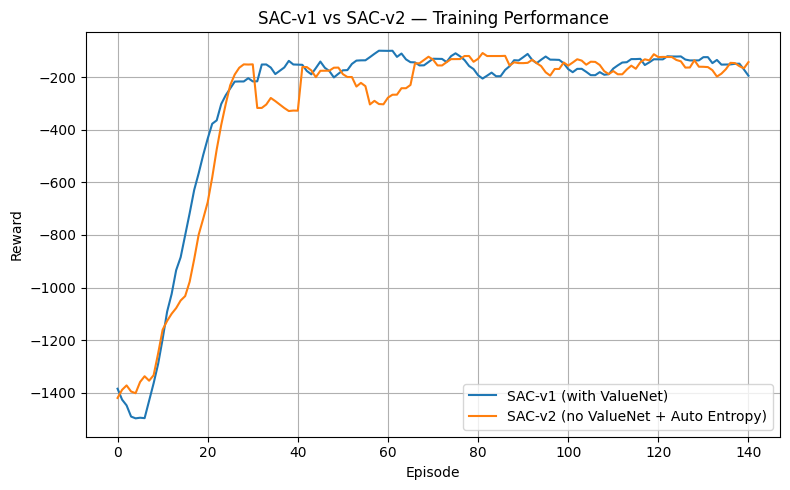


📹 บันทึกวิดีโอ side-by-side ไปที่: sac_comparison.mp4


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


✅ บันทึกวิดีโอเสร็จแล้ว

✅ บันทึกโมเดลเรียบร้อยแล้ว: SAC_v1_actor.pth, SAC_v2_actor.pth



In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import time
import imageio
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===========================================
# Shared Components
# ===========================================
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.stack, zip(*batch))
        return (
            torch.FloatTensor(s).to(device),
            torch.FloatTensor(a).to(device),
            torch.FloatTensor(r).unsqueeze(1).to(device),
            torch.FloatTensor(s2).to(device),
            torch.FloatTensor(d).unsqueeze(1).to(device)
        )

    def __len__(self):
        return len(self.buffer)


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        self.max_action = max_action

    def forward(self, state):
        mean = self.net(state)
        std = torch.exp(self.log_std)
        dist = torch.distributions.Normal(mean, std)
        x_t = dist.rsample()
        y_t = torch.tanh(x_t)
        action = y_t * self.max_action
        log_prob = dist.log_prob(x_t) - torch.log(1 - y_t.pow(2) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True).clamp(min=-20, max=2)
        return action, log_prob

    # helper to get deterministic mean-action (for eval)
    def mean_action(self, state):
        mean = self.net(state)
        return torch.tanh(mean) * self.max_action


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        def create_net():
            return nn.Sequential(
                nn.Linear(state_dim + action_dim, 256), nn.ReLU(),
                nn.Linear(256, 256), nn.ReLU(),
                nn.Linear(256, 1)
            )
        self.q1 = create_net()
        self.q2 = create_net()

    def forward(self, state, action):
        sa = torch.cat([state, action], 1)
        return self.q1(sa), self.q2(sa)


# ===========================================
# SAC v1 (มี Value Network)
# ===========================================
class ValueNet(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, s):
        return self.net(s)


class SAC_v1:
    def __init__(self, state_dim, action_dim, max_action, gamma=0.99, tau=0.005, alpha=0.2):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.critic = Critic(state_dim, action_dim).to(device)
        self.value = ValueNet(state_dim).to(device)
        self.target_value = ValueNet(state_dim).to(device)
        self.target_value.load_state_dict(self.value.state_dict())

        self.gamma, self.tau, self.alpha = gamma, tau, alpha
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=3e-4)
        self.value_optim = optim.Adam(self.value.parameters(), lr=3e-4)

    def select_action(self, state, eval_mode=False):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        with torch.no_grad():
            if eval_mode:
                action = self.actor.mean_action(state)
                return action.cpu().numpy()[0]
            else:
                a, _ = self.actor(state)
                return a.cpu().detach().numpy()[0]

    def train(self, replay_buffer, batch_size=256):
        s, a, r, s2, d = replay_buffer.sample(batch_size)

        with torch.no_grad():
            next_v = self.target_value(s2)
            target_q = r + (1 - d) * self.gamma * next_v

        q1, q2 = self.critic(s, a)
        critic_loss = ((q1 - target_q)**2 + (q2 - target_q)**2).mean()

        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        v = self.value(s)
        new_a, log_p = self.actor(s)
        q1_pi, q2_pi = self.critic(s, new_a)
        q_pi = torch.min(q1_pi, q2_pi)
        v_target = q_pi - self.alpha * log_p
        value_loss = ((v - v_target.detach())**2).mean()

        self.value_optim.zero_grad()
        value_loss.backward()
        self.value_optim.step()

        actor_loss = (self.alpha * log_p - q_pi).mean()
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        for t, s_ in zip(self.target_value.parameters(), self.value.parameters()):
            t.data.copy_(self.tau * s_.data + (1 - self.tau) * t.data)


# ===========================================
# SAC v2 (ไม่มี ValueNet + Auto Alpha)
# ===========================================
class SAC_v2:
    def __init__(self, state_dim, action_dim, max_action, gamma=0.99, tau=0.005):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.critic = Critic(state_dim, action_dim).to(device)
        self.target_critic = Critic(state_dim, action_dim).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.gamma, self.tau = gamma, tau
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=3e-4)

        # Automatic entropy tuning
        self.target_entropy = -action_dim
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optim = optim.Adam([self.log_alpha], lr=3e-4)

    def select_action(self, state, eval_mode=False):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        with torch.no_grad():
            if eval_mode:
                action = self.actor.mean_action(state)
                return action.cpu().numpy()[0]
            else:
                a, _ = self.actor(state)
                return a.cpu().detach().numpy()[0]

    def train(self, replay_buffer, batch_size=256):
        s, a, r, s2, d = replay_buffer.sample(batch_size)

        with torch.no_grad():
            next_a, next_log_p = self.actor(s2)
            q1_next, q2_next = self.target_critic(s2, next_a)
            q_target = torch.min(q1_next, q2_next) - self.log_alpha.exp() * next_log_p
            target_q = r + (1 - d) * self.gamma * q_target

        q1, q2 = self.critic(s, a)
        critic_loss = ((q1 - target_q)**2 + (q2 - target_q)**2).mean()

        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        new_a, log_p = self.actor(s)
        q1_pi, q2_pi = self.critic(s, new_a)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (self.log_alpha.exp() * log_p - q_pi).mean()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        # update alpha
        alpha_loss = -(self.log_alpha * (log_p + self.target_entropy).detach()).mean()
        self.alpha_optim.zero_grad()
        alpha_loss.backward()
        self.alpha_optim.step()

        for t, s_ in zip(self.target_critic.parameters(), self.critic.parameters()):
            t.data.copy_(self.tau * s_.data + (1 - self.tau) * t.data)


# ===========================================
# Experiment Runner
# ===========================================
def run_experiment(env_name="Pendulum-v1", episodes=150, max_steps=200):
    env1, env2 = gym.make(env_name), gym.make(env_name)
    state_dim = env1.observation_space.shape[0]
    action_dim = env1.action_space.shape[0]
    max_action = float(env1.action_space.high[0])

    agent1 = SAC_v1(state_dim, action_dim, max_action)
    agent2 = SAC_v2(state_dim, action_dim, max_action)
    rb1, rb2 = ReplayBuffer(), ReplayBuffer()

    rewards_v1, rewards_v2 = [], []

    for ep in range(episodes):
        s1, _ = env1.reset()
        s2, _ = env2.reset()
        ep_r1 = ep_r2 = 0

        for _ in range(max_steps):
            a1 = agent1.select_action(s1)
            a2 = agent2.select_action(s2)
            ns1, r1, term1, trunc1, _ = env1.step(a1)
            ns2, r2, term2, trunc2, _ = env2.step(a2)
            d1, d2 = term1 or trunc1, term2 or trunc2
            rb1.push(s1, a1, r1, ns1, d1)
            rb2.push(s2, a2, r2, ns2, d2)
            s1, s2 = ns1, ns2
            ep_r1 += r1
            ep_r2 += r2

            if len(rb1) > 1000:
                agent1.train(rb1)
                agent2.train(rb2)
            if d1 and d2:
                break

        rewards_v1.append(ep_r1)
        rewards_v2.append(ep_r2)
        print(f"Ep {ep+1}/{episodes} | SAC-v1: {ep_r1:.2f} | SAC-v2: {ep_r2:.2f}")

    env1.close(), env2.close()
    return rewards_v1, rewards_v2, agent1, agent2


def evaluate_render(agent1, agent2, env_name="Pendulum-v1", episodes=2, delay=0.02):
    """
    แสดงการทำงานของ SAC-v1 และ SAC-v2 แบบ render ให้เห็นภาพ (ใช้หน้าต่าง GUI)
    """
    print("\n🎥 เริ่มการเปรียบเทียบแบบ Render\n")
    env1 = gym.make(env_name, render_mode="human")
    env2 = gym.make(env_name, render_mode="human")

    for ep in range(episodes):
        state1, _ = env1.reset()
        state2, _ = env2.reset()
        ep_r1 = ep_r2 = 0
        done1 = done2 = False

        print(f"==== Episode {ep+1}/{episodes} ====")
        while not (done1 and done2):
            if not done1:
                action1 = agent1.select_action(state1, eval_mode=True)
                next_state1, reward1, term1, trunc1, _ = env1.step(action1)
                done1 = term1 or trunc1
                ep_r1 += reward1
                state1 = next_state1

            if not done2:
                action2 = agent2.select_action(state2, eval_mode=True)
                next_state2, reward2, term2, trunc2, _ = env2.step(action2)
                done2 = term2 or trunc2
                ep_r2 += reward2
                state2 = next_state2

            time.sleep(delay)

        print(f"✅ SAC-v1 Reward: {ep_r1:.2f} | SAC-v2 Reward: {ep_r2:.2f}\n")

    env1.close()
    env2.close()
    print("🎬 จบการแสดงผล\n")


def evaluate_and_record_side_by_side(agent1, agent2, filename="comparison.mp4",
                                     env_name="Pendulum-v1", episodes=2, fps=30, max_steps=400):
    """
    Render both envs in 'rgb_array' mode, concatenate frames side-by-side, and save as MP4.
    """
    print(f"\n📹 บันทึกวิดีโอ side-by-side ไปที่: {filename}")
    env1 = gym.make(env_name, render_mode="rgb_array")
    env2 = gym.make(env_name, render_mode="rgb_array")

    writer = imageio.get_writer(filename, fps=fps, codec="libx264", quality=8)

    for ep in range(episodes):
        s1, _ = env1.reset()
        s2, _ = env2.reset()
        done1 = done2 = False
        step = 0
        while not (done1 and done2) and step < max_steps:
            # actions (deterministic eval)
            a1 = agent1.select_action(s1, eval_mode=True)
            a2 = agent2.select_action(s2, eval_mode=True)

            ns1, r1, term1, trunc1, _ = env1.step(a1)
            ns2, r2, term2, trunc2, _ = env2.step(a2)
            done1 = term1 or trunc1
            done2 = term2 or trunc2

            # render frames as arrays
            f1 = env1.render()
            f2 = env2.render()

            # convert to PIL for resizing to same height
            im1 = Image.fromarray(f1)
            im2 = Image.fromarray(f2)

            # Resize to same height (choose min height)
            h = min(im1.height, im2.height)
            w1 = int(im1.width * (h / im1.height))
            w2 = int(im2.width * (h / im2.height))
            im1 = im1.resize((w1, h), Image.BILINEAR)
            im2 = im2.resize((w2, h), Image.BILINEAR)

            # concatenate horizontally
            total_w = w1 + w2
            new_im = Image.new('RGB', (total_w, h))
            new_im.paste(im1, (0, 0))
            new_im.paste(im2, (w1, 0))

            writer.append_data(np.array(new_im))

            s1, s2 = ns1, ns2
            step += 1

    writer.close()
    env1.close()
    env2.close()
    print("✅ บันทึกวิดีโอเสร็จแล้ว")


# ===========================================
# Main Run & Plot
# ===========================================
if __name__ == "__main__":
    print("\n🚀 เริ่มการเทรน SAC-v1 และ SAC-v2\n")
    env_name = "Pendulum-v1"
    episodes = 150
    max_steps = 200

    rewards_v1, rewards_v2, agent_v1, agent_v2 = run_experiment(env_name=env_name, episodes=episodes, max_steps=max_steps)

    # Plot training result
    def smooth(x, n=10): return np.convolve(x, np.ones(n)/n, mode="valid")

    plt.figure(figsize=(8, 5))
    plt.plot(smooth(rewards_v1), label="SAC-v1 (with ValueNet)")
    plt.plot(smooth(rewards_v2), label="SAC-v2 (no ValueNet + Auto Entropy)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("SAC-v1 vs SAC-v2 — Training Performance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evaluate with GUI render (optional)
    # evaluate_render(agent_v1, agent_v2, env_name=env_name, episodes=2, delay=0.02)

    # Record side-by-side mp4 (deterministic eval)
    evaluate_and_record_side_by_side(agent_v1, agent_v2,
                                     filename="sac_comparison.mp4",
                                     env_name=env_name, episodes=20, fps=30, max_steps=400)

    # Save models
    #torch.save(agent_v1.actor.state_dict(), "SAC_v1_actor.pth")
    #torch.save(agent_v2.actor.state_dict(), "SAC_v2_actor.pth")
    print("\n✅ บันทึกโมเดลเรียบร้อยแล้ว: SAC_v1_actor.pth, SAC_v2_actor.pth\n")


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import imageio
import time

# ============================================================
# Device
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================================
# RC_Tank_Env - Simulated RC Tank
# ============================================================
class RC_Tank_Env:
    def __init__(self, R=100, C=2.0, dt=0.1,
                 control_mode='voltage',
                 setpoint_level=5.0,
                 level_max=10.0,
                 max_action_volt=24.0,
                 max_action_current=5.0):
        if control_mode not in ['voltage', 'current']:
            raise ValueError("control_mode must be 'voltage' or 'current'")

        self.R, self.C, self.dt = R, C, dt
        self.mode = control_mode
        self.setpoint_level = setpoint_level
        self.level_max = level_max
        self.max_action_volt = max_action_volt
        self.max_action_current = max_action_current
        self.level = 0.0
        self.time = 0.0

    def reset(self):
        self.level = np.random.uniform(0, self.level_max)
        self.time = 0.0
        return np.array([self.level], dtype=np.float32), {}

    def step(self, action):
        if isinstance(action, np.ndarray):
            action = float(action[0])

        if self.mode == 'voltage':
            action = np.clip(action, 0, self.max_action_volt)
            current = (action - self.level) / self.R
            delta_level = (current / self.C) * self.dt
        else:
            action = np.clip(action, 0, self.max_action_current)
            net_flow = action - (self.level / self.R)
            delta_level = (net_flow / self.C) * self.dt

        self.level += delta_level
        self.level = np.clip(self.level, 0, self.level_max)
        self.time += self.dt

        error = self.setpoint_level - self.level
        reward = -abs(error)

        done = abs(error) <= 0.1
        truncated = self.time >= 50.0
        return np.array([self.level], dtype=np.float32), reward, done, truncated, {}

    def render(self, mode='rgb_array'):
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.bar(0, self.level, color='skyblue', width=0.3)
        ax.axhline(self.setpoint_level, color='r', linestyle='--', label='setpoint')
        ax.set_ylim(0, self.level_max)
        ax.set_xlim(-0.5, 0.5)
        ax.set_ylabel('Water Level')
        ax.legend()
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        plt.close(fig)
        return image[..., :3]


# ============================================================
# Replay Buffer
# ============================================================
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.stack, zip(*batch))
        return (
            torch.FloatTensor(s).to(device),
            torch.FloatTensor(a).to(device),
            torch.FloatTensor(r).unsqueeze(1).to(device),
            torch.FloatTensor(s2).to(device),
            torch.FloatTensor(d).unsqueeze(1).to(device)
        )

    def __len__(self):
        return len(self.buffer)


# ============================================================
# Actor-Critic Networks
# ============================================================
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        self.max_action = max_action

    def forward(self, state):
        mean = self.net(state)
        std = torch.exp(self.log_std)
        dist = torch.distributions.Normal(mean, std)
        x_t = dist.rsample()
        y_t = torch.tanh(x_t)
        action = y_t * self.max_action
        log_prob = dist.log_prob(x_t) - torch.log(1 - y_t.pow(2) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        return action, log_prob

    def mean_action(self, state):
        mean = self.net(state)
        return torch.tanh(mean) * self.max_action


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        def make_net():
            return nn.Sequential(
                nn.Linear(state_dim + action_dim, 128), nn.ReLU(),
                nn.Linear(128, 128), nn.ReLU(),
                nn.Linear(128, 1)
            )
        self.q1 = make_net()
        self.q2 = make_net()

    def forward(self, s, a):
        sa = torch.cat([s, a], 1)
        return self.q1(sa), self.q2(sa)


# ============================================================
# SAC-v2 Agent
# ============================================================
class SAC_v2:
    def __init__(self, state_dim, action_dim, max_action, gamma=0.99, tau=0.005):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.critic = Critic(state_dim, action_dim).to(device)
        self.target_critic = Critic(state_dim, action_dim).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.gamma, self.tau = gamma, tau
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=3e-4)

        self.target_entropy = -action_dim
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optim = optim.Adam([self.log_alpha], lr=3e-4)

    def select_action(self, state, eval_mode=False):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        with torch.no_grad():
            if eval_mode:
                action = self.actor.mean_action(state)
            else:
                action, _ = self.actor(state)
        return action.cpu().numpy()[0]

    def train(self, replay_buffer, batch_size=64):
        if len(replay_buffer) < batch_size:
            return

        s, a, r, s2, d = replay_buffer.sample(batch_size)

        with torch.no_grad():
            next_a, next_log_p = self.actor(s2)
            q1_next, q2_next = self.target_critic(s2, next_a)
            q_target = torch.min(q1_next, q2_next) - self.log_alpha.exp() * next_log_p
            target_q = r + (1 - d) * self.gamma * q_target

        q1, q2 = self.critic(s, a)
        critic_loss = ((q1 - target_q)**2 + (q2 - target_q)**2).mean()
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        new_a, log_p = self.actor(s)
        q1_pi, q2_pi = self.critic(s, new_a)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (self.log_alpha.exp() * log_p - q_pi).mean()
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        alpha_loss = -(self.log_alpha * (log_p + self.target_entropy).detach()).mean()
        self.alpha_optim.zero_grad()
        alpha_loss.backward()
        self.alpha_optim.step()

        for t, s_ in zip(self.target_critic.parameters(), self.critic.parameters()):
            t.data.copy_(self.tau * s_.data + (1 - self.tau) * t.data)


# ============================================================
# Training and Evaluation
# ============================================================
def train_sac_rc(episodes=200, max_steps=200):
    env = RC_Tank_Env()
    state_dim = 1
    action_dim = 1
    max_action = env.max_action_volt

    agent = SAC_v2(state_dim, action_dim, max_action)
    rb = ReplayBuffer()

    rewards = []

    for ep in range(episodes):
        s, _ = env.reset()
        ep_r = 0.0
        for _ in range(max_steps):
            a = agent.select_action(s)
            s2, r, done, trunc, _ = env.step(a)
            rb.push(s, a, r, s2, float(done))
            s = s2
            ep_r += r
            agent.train(rb, 64)
            if done or trunc:
                break
        rewards.append(ep_r)
        print(f"Ep {ep+1}/{episodes} | Reward: {float(ep_r):.2f}")

    return agent, rewards


def evaluate_and_record(agent, filename="sac_rc_tank.mp4", episodes=3, max_steps=900, fps=30):
    env = RC_Tank_Env()
    writer = imageio.get_writer(filename, fps=fps)
    print(f"\n🎥 บันทึกวิดีโอไปที่ {filename}")

    for ep in range(episodes):
        s, _ = env.reset()
        done = False
        for _ in range(max_steps):
            a = agent.select_action(s, eval_mode=True)
            s, r, done, trunc, _ = env.step(a)
            frame = env.render()
            writer.append_data(frame)
            if done or trunc:
                break
        print(ep)
    writer.close()
    print("✅ เสร็จสิ้นการบันทึกวิดีโอ\n")


# ============================================================
# Main Entry
# ============================================================
if __name__ == "__main__":
    start = time.time()
    agent, rewards = train_sac_rc(episodes=150, max_steps=900)
    print(f"\n🕒 Training Time: {time.time() - start:.2f} sec")

    plt.figure(figsize=(8, 5))
    plt.plot(rewards, label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("SAC-v2 Training on RC_Tank_Env")
    plt.grid(True)
    plt.legend()
    plt.show()

    evaluate_and_record(agent, "sac_rc_tank.mp4", episodes=20, max_steps=300, fps=20)


Ep 1/150 | Reward: -2041.59
Ep 2/150 | Reward: -2035.68
Ep 3/150 | Reward: -1273.01
Ep 4/150 | Reward: -552.79
Ep 5/150 | Reward: -378.00
Ep 6/150 | Reward: -572.64
Ep 7/150 | Reward: -1663.30
Ep 8/150 | Reward: -1291.41
Ep 9/150 | Reward: -1681.95
Ep 10/150 | Reward: -583.95
Ep 11/150 | Reward: -360.05
Ep 12/150 | Reward: -1474.32
Ep 13/150 | Reward: -1047.97
Ep 14/150 | Reward: -643.11
Ep 15/150 | Reward: -3.34
Ep 16/150 | Reward: -1047.20
Ep 17/150 | Reward: -818.71
Ep 18/150 | Reward: -931.95
Ep 19/150 | Reward: -803.58
Ep 20/150 | Reward: -608.73
Ep 21/150 | Reward: -1524.45
Ep 22/150 | Reward: -385.03
Ep 23/150 | Reward: -770.38
Ep 24/150 | Reward: -1814.85
Ep 25/150 | Reward: -142.44
Ep 26/150 | Reward: -0.02
Ep 27/150 | Reward: -716.76
Ep 28/150 | Reward: -13.75
Ep 29/150 | Reward: -0.02
Ep 30/150 | Reward: -383.90
Ep 31/150 | Reward: -1872.05
Ep 32/150 | Reward: -1764.16
Ep 33/150 | Reward: -1633.95
Ep 34/150 | Reward: -332.18
Ep 35/150 | Reward: -1695.47
Ep 36/150 | Reward: -

C:\Users\phakh\AppData\Local\Temp\ipykernel_13308\3135269046.py:284: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
✅ เสร็จสิ้นการบันทึกวิดีโอ



[Ep 1/150] Reward: -2315.681 | Buffer: 200 | Total steps: 200
[Ep 2/150] Reward: -2549.486 | Buffer: 400 | Total steps: 400
[Ep 3/150] Reward: -110.719 | Buffer: 419 | Total steps: 419
[Ep 4/150] Reward: -36.451 | Buffer: 430 | Total steps: 430
[Ep 5/150] Reward: -2676.977 | Buffer: 630 | Total steps: 630
[Ep 6/150] Reward: -2448.659 | Buffer: 830 | Total steps: 830
[Ep 7/150] Reward: -2624.345 | Buffer: 1030 | Total steps: 1030
[Ep 8/150] Reward: -2151.156 | Buffer: 1230 | Total steps: 1230
[Ep 9/150] Reward: -135.034 | Buffer: 1254 | Total steps: 1254
[Ep 10/150] Reward: -347.377 | Buffer: 1290 | Total steps: 1290
[Ep 11/150] Reward: -1785.355 | Buffer: 1490 | Total steps: 1490
[Ep 12/150] Reward: -205.736 | Buffer: 1515 | Total steps: 1515
[Ep 13/150] Reward: -180.440 | Buffer: 1539 | Total steps: 1539
[Ep 14/150] Reward: -96.403 | Buffer: 1564 | Total steps: 1564
[Ep 15/150] Reward: -149.598 | Buffer: 1588 | Total steps: 1588
[Ep 16/150] Reward: -108.272 | Buffer: 1606 | Total step

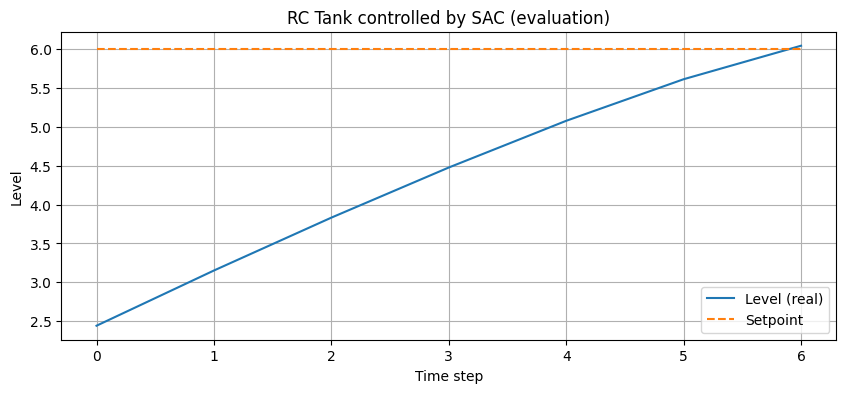

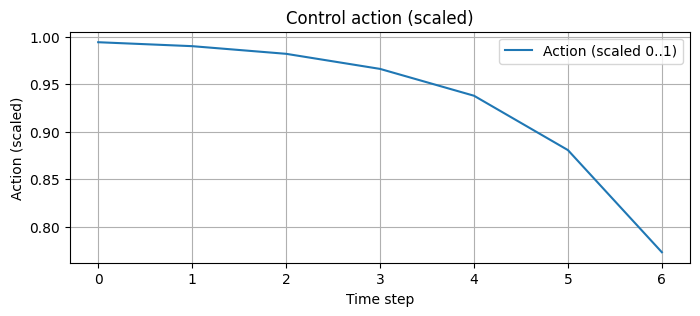

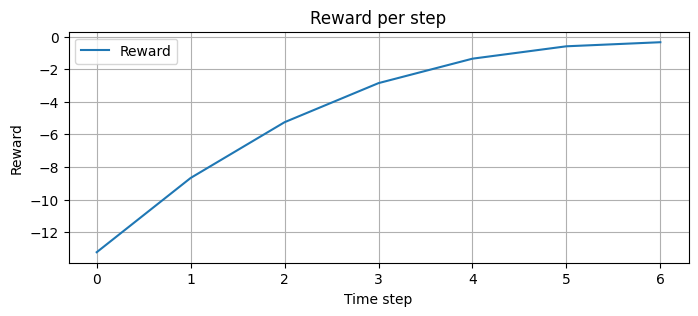

In [1]:
"""
sac_rc_tank_single_file.py
Single-file example: SAC + RC_Tank_Env + MinMaxScaler
"""

import numpy as np
import random
import copy
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# -------------------------
# RC Tank Environment
# -------------------------
class RC_Tank_Env:
    """
    Simple RC-Tank simulator with scaling support (MinMaxScaler).
    State: [level] (scaled if use_scaler=True)
    Action: scalar (voltage or current) scaled to [0,1] when use_scaler=True
    """

    def __init__(self, R=1.5, C=2.0, dt=0.1,
                 control_mode='voltage',
                 setpoint_level=5.0,
                 level_max=10.0,
                 max_action_volt=24.0,
                 max_action_current=5.0,
                 use_scaler=True):
        # params
        if control_mode not in ['voltage', 'current']:
            raise ValueError("control_mode must be 'voltage' or 'current'")

        self.R = R
        self.C = C
        self.dt = dt
        self.mode = control_mode
        self.setpoint_level = setpoint_level
        self.level_max = level_max
        self.max_action_volt = max_action_volt
        self.max_action_current = max_action_current

        # internal state
        self.level = 0.0
        self.time = 0.0

        # scaling
        self.use_scaler = use_scaler
        if use_scaler:
            # state scaler transforms level in [0, level_max] -> [0,1]
            self.state_scaler = MinMaxScaler(feature_range=(0.0, 1.0))
            self.state_scaler.fit(np.array([[0.0], [self.level_max]]))
            # action scaler transforms action_unit in [0, max_action] -> [0,1]
            self.action_scaler = MinMaxScaler(feature_range=(0.0, 1.0))
            if self.mode == 'voltage':
                self.action_scaler.fit(np.array([[0.0], [self.max_action_volt]]))
            else:
                self.action_scaler.fit(np.array([[0.0], [self.max_action_current]]))

    def reset(self, initial_level=None):
        """Reset environment. Returns state (1D np array)."""
        if initial_level is None:
            self.level = np.random.uniform(0.0, min(2.0, self.level_max))
        else:
            self.level = float(np.clip(initial_level, 0.0, self.level_max))
        self.time = 0.0
        done = False

        state = np.array([self.level], dtype=np.float32)
        if self.use_scaler:
            state = self.state_scaler.transform(state.reshape(-1, 1)).flatten().astype(np.float32)
        return state, done

    def step(self, action_scaled):
        """
        Step with `action_scaled` in scaled domain (0..1) if use_scaler True.
        Returns: next_state (1D np array), reward (float), done (bool)
        """
        # map action back to real unit
        if self.use_scaler:
            # action_scaled might be scalar or array-like
            a_arr = np.array([action_scaled], dtype=np.float32).reshape(-1, 1)
            action = float(self.action_scaler.inverse_transform(a_arr)[0, 0])
        else:
            action = float(action_scaled)

        # dynamics
        if self.mode == 'voltage':
            # simple linear relation: current = (V - level)/R
            action = np.clip(action, 0.0, self.max_action_volt)
            current = (action - self.level) / self.R
            delta_level = (current / self.C) * self.dt
        else:
            action = np.clip(action, 0.0, self.max_action_current)
            net_flow = action - (self.level / self.R)
            delta_level = (net_flow / self.C) * self.dt

        # update
        self.level += delta_level
        self.level = float(np.clip(self.level, 0.0, self.level_max))
        self.time += self.dt

        # reward design: negative squared error + small penalty on action
        error = self.setpoint_level - self.level
        reward = - (error ** 2) - 0.001 * (action ** 2)

        done = abs(error) <= 0.05  # success band

        state = np.array([self.level], dtype=np.float32)
        if self.use_scaler:
            state = self.state_scaler.transform(state.reshape(-1, 1)).flatten().astype(np.float32)
        return state, float(reward), bool(done)

# -------------------------
# Replay Buffer
# -------------------------
class ReplayBuffer:
    def __init__(self, max_size=200000):
        self.max_size = max_size
        self.storage = []
        self.next_idx = 0

    def add(self, state, action, reward, next_state, done):
        data = (np.array(state, dtype=np.float32),
                np.array(action, dtype=np.float32),
                float(reward),
                np.array(next_state, dtype=np.float32),
                float(done))
        if len(self.storage) < self.max_size:
            self.storage.append(data)
        else:
            self.storage[self.next_idx] = data
            self.next_idx = (self.next_idx + 1) % self.max_size

    def sample(self, batch_size):
        idxs = random.sample(range(len(self.storage)), batch_size)
        states, actions, rewards, next_states, dones = zip(*[self.storage[i] for i in idxs])
        return (
            torch.FloatTensor(np.stack(states)),
            torch.FloatTensor(np.stack(actions)),
            torch.FloatTensor(np.array(rewards)).unsqueeze(1),
            torch.FloatTensor(np.stack(next_states)),
            torch.FloatTensor(np.array(dones)).unsqueeze(1)
        )

    def size(self):
        return len(self.storage)

# -------------------------
# Neural networks: Actor & Critic
# -------------------------
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action=1.0, hidden=128):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, hidden)
        self.l2 = nn.Linear(hidden, hidden)
        self.mean = nn.Linear(hidden, action_dim)
        self.log_std = nn.Linear(hidden, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, -20, 2)
        std = torch.exp(log_std)
        return mean, std

    def sample(self, state):
        mean, std = self.forward(state)
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # reparam
        y_t = torch.tanh(x_t)
        action = y_t * self.max_action
        # log prob (account for tanh)
        log_prob = normal.log_prob(x_t) - torch.log(1 - y_t.pow(2) + 1e-6)
        log_prob = log_prob.sum(-1, keepdim=True)
        return action, log_prob

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=128):
        super(Critic, self).__init__()
        # Q1
        self.q1_l1 = nn.Linear(state_dim + action_dim, hidden)
        self.q1_l2 = nn.Linear(hidden, hidden)
        self.q1_out = nn.Linear(hidden, 1)
        # Q2
        self.q2_l1 = nn.Linear(state_dim + action_dim, hidden)
        self.q2_l2 = nn.Linear(hidden, hidden)
        self.q2_out = nn.Linear(hidden, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], dim=1)
        q1 = F.relu(self.q1_l1(sa))
        q1 = F.relu(self.q1_l2(q1))
        q1 = self.q1_out(q1)
        q2 = F.relu(self.q2_l1(sa))
        q2 = F.relu(self.q2_l2(q2))
        q2 = self.q2_out(q2)
        return q1, q2

# -------------------------
# SAC Agent
# -------------------------
class SACAgent:
    def __init__(self, state_dim, action_dim, max_action=1.0,
                 device='cpu', gamma=0.99, tau=0.005, alpha=0.2,
                 actor_lr=3e-4, critic_lr=3e-4, automatic_entropy_tuning=True):
        self.device = torch.device(device)
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha
        self.automatic_entropy_tuning = automatic_entropy_tuning

        # networks
        self.actor = Actor(state_dim, action_dim, max_action).to(self.device)
        self.critic = Critic(state_dim, action_dim).to(self.device)
        self.critic_target = copy.deepcopy(self.critic).to(self.device)

        # optimizers
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=critic_lr)

        # entropy tuning
        if self.automatic_entropy_tuning:
            # target entropy heuristic: -|action_dim|
            self.target_entropy = -float(action_dim)
            self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
            self.alpha_optim = optim.Adam([self.log_alpha], lr=actor_lr)
        else:
            self.log_alpha = None
            self.alpha_optim = None

    def select_action(self, state, evaluate=False):
        state_t = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if evaluate:
            with torch.no_grad():
                mean, _ = self.actor.forward(state_t)
                action = torch.tanh(mean) * self.actor.max_action
            return action.cpu().numpy().flatten()
        else:
            with torch.no_grad():
                action, _ = self.actor.sample(state_t)
            return action.cpu().numpy().flatten()

    def train(self, replay_buffer, batch_size=64):
        # sample
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)
        state = state.to(self.device)
        action = action.to(self.device)
        reward = reward.to(self.device)
        next_state = next_state.to(self.device)
        done = done.to(self.device)

        # target actions
        with torch.no_grad():
            next_action, next_log_prob = self.actor.sample(next_state)
            q1_next, q2_next = self.critic_target(next_state, next_action)
            q_next = torch.min(q1_next, q2_next) - (self.alpha * next_log_prob)
            q_target = reward + (1 - done) * self.gamma * q_next

        # critic loss
        current_q1, current_q2 = self.critic(state, action)
        critic_loss = F.mse_loss(current_q1, q_target) + F.mse_loss(current_q2, q_target)

        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        # actor loss
        pi, log_pi = self.actor.sample(state)
        q1_pi, q2_pi = self.critic(state, pi)
        min_q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (self.alpha * log_pi - min_q_pi).mean()

        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        # update alpha if automatic
        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()
            self.alpha = float(self.log_alpha.exp().item())

        # soft update
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        return {
            'critic_loss': critic_loss.item(),
            'actor_loss': actor_loss.item(),
            'alpha': self.alpha
        }

    def save(self, path_prefix="sac"):
        torch.save(self.actor.state_dict(), path_prefix + "_actor.pth")
        torch.save(self.critic.state_dict(), path_prefix + "_critic.pth")

    def load(self, path_prefix="sac"):
        self.actor.load_state_dict(torch.load(path_prefix + "_actor.pth", map_location=self.device))
        self.critic.load_state_dict(torch.load(path_prefix + "_critic.pth", map_location=self.device))

# -------------------------
# Training / Main
# -------------------------
def main():
    # 1) create env
    env = RC_Tank_Env(control_mode='voltage', setpoint_level=6.0, use_scaler=True)

    # agent sees scaled state and produces scaled action in [~ -1..1 via tanh], but we use MaxAction=1.0
    state_dim = 1  # only "level" as feature (scaled)
    action_dim = 1
    max_action = 1.0

    # create agent & buffer
    device = 'cpu'  # set 'cuda' if GPU available
    agent = SACAgent(state_dim, action_dim, max_action, device=device, automatic_entropy_tuning=True)
    buffer = ReplayBuffer(max_size=200000)

    # training params
    episodes = 150
    max_steps_per_episode = 200
    start_steps = 1000  # collect random actions until this many steps
    total_steps = 0
    batch_size = 64

    # training loop
    ep_rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        ep_reward = 0.0
        for t in range(max_steps_per_episode):
            if buffer.size() < start_steps:
                # random scaled action in [0,1]
                action = np.array([random.random()], dtype=np.float32)
            else:
                action = agent.select_action(state)  # returns numpy array
                # action is in (-1..1) due tanh; but Actor.sample uses tanh(x)*max_action (max_action=1.0)
                # we want action in [0,1] as scaler expects; map from [-1,1] -> [0,1]
                action = (action + 1.0) / 2.0
                action = np.clip(action, 0.0, 1.0).astype(np.float32)

            next_state, reward, done = env.step(action)
            buffer.add(state.astype(np.float32), action.astype(np.float32), reward, next_state.astype(np.float32), float(done))

            state = next_state
            ep_reward += reward
            total_steps += 1

            # train when enough samples
            if buffer.size() > batch_size and buffer.size() >= start_steps:
                info = agent.train(buffer, batch_size=batch_size)

            if done:
                break

        ep_rewards.append(ep_reward)
        print(f"[Ep {ep+1}/{episodes}] Reward: {ep_reward:.3f} | Buffer: {buffer.size()} | Total steps: {total_steps}")

    # save model
    agent.save("sac_rc_tank")

    # -------------------------
    # Test / Visualize one rollout (evaluation)
    # -------------------------
    state, _ = env.reset()
    levels = []
    setpoints = []
    actions = []
    rewards = []

    for t in range(200):
        # deterministic evaluation: use actor mean mapped by tanh
        action_t = agent.select_action(state, evaluate=True)  # in (-1..1)
        action_scaled = (action_t + 1.0) / 2.0
        action_scaled = np.clip(action_scaled, 0.0, 1.0).astype(np.float32)
        next_state, reward, done = env.step(action_scaled)

        levels.append(env.level)         # real (unscaled) level
        setpoints.append(env.setpoint_level)
        actions.append(action_scaled[0])
        rewards.append(reward)

        state = next_state
        if done:
            break

    # plot
    plt.figure(figsize=(10,4))
    plt.plot(levels, label="Level (real)")
    plt.plot(setpoints, '--', label="Setpoint")
    plt.xlabel("Time step")
    plt.ylabel("Level")
    plt.title("RC Tank controlled by SAC (evaluation)")
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(8,3))
    plt.plot(actions, label="Action (scaled 0..1)")
    plt.xlabel("Time step")
    plt.ylabel("Action (scaled)")
    plt.title("Control action (scaled)")
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(8,3))
    plt.plot(rewards, label="Reward")
    plt.xlabel("Time step")
    plt.ylabel("Reward")
    plt.title("Reward per step")
    plt.legend()
    plt.grid(True)

    plt.show()


if __name__ == "__main__":
    main()


Ep 1/300 | Reward: -1750.15
Ep 2/300 | Reward: -1227.41
Ep 3/300 | Reward: -942.02
Ep 4/300 | Reward: -668.85
Ep 5/300 | Reward: -562.33
Ep 6/300 | Reward: -1352.64
Ep 7/300 | Reward: -733.35
Ep 8/300 | Reward: -1015.34
Ep 9/300 | Reward: -575.13
Ep 10/300 | Reward: -1806.55
Ep 11/300 | Reward: -601.17
Ep 12/300 | Reward: -1837.45
Ep 13/300 | Reward: -459.45
Ep 14/300 | Reward: -1137.67
Ep 15/300 | Reward: -745.80
Ep 16/300 | Reward: -1019.80
Ep 17/300 | Reward: -975.17
Ep 18/300 | Reward: -1050.49
Ep 19/300 | Reward: -1230.49
Ep 20/300 | Reward: -630.36
Ep 21/300 | Reward: -799.81
Ep 22/300 | Reward: -687.59
Ep 23/300 | Reward: -451.94
Ep 24/300 | Reward: -1222.22
Ep 25/300 | Reward: -196.17
Ep 26/300 | Reward: -1474.11
Ep 27/300 | Reward: -62.77
Ep 28/300 | Reward: -28.81
Ep 29/300 | Reward: -0.07
Ep 30/300 | Reward: -546.22
Ep 31/300 | Reward: -1567.59
Ep 32/300 | Reward: -329.41
Ep 33/300 | Reward: -1167.44
Ep 34/300 | Reward: -437.61
Ep 35/300 | Reward: -1214.44
Ep 36/300 | Reward

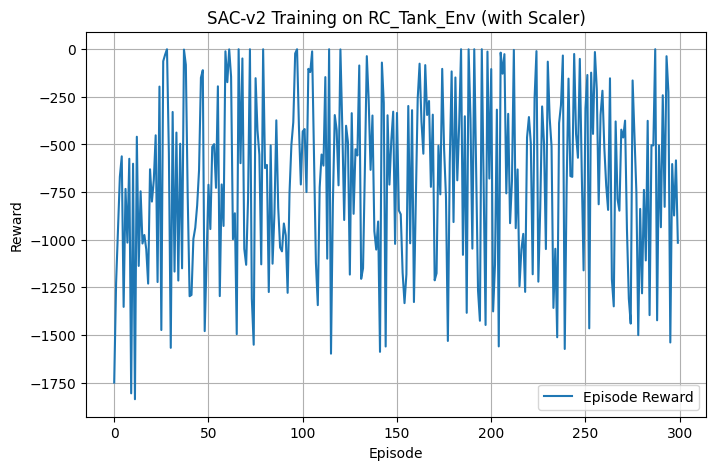


🎥 กำลังบันทึกวิดีโอที่ sac_rc_tank_with_actions.mp4
✅ เสร็จสิ้นการบันทึกวิดีโอ



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import imageio
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# ============================================================
# Device
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================================
# RC_Tank_Env - Simulated RC Tank
# ============================================================
class RC_Tank_Env:
    def __init__(self, R=100, C=2.0, dt=0.1,
                 control_mode='voltage',
                 setpoint_level=5.0,
                 level_max=10.0,
                 max_action_volt=24.0,
                 max_action_current=5.0,
                 use_scaler=True):
        if control_mode not in ['voltage', 'current']:
            raise ValueError("control_mode must be 'voltage' or 'current'")

        self.R, self.C, self.dt = R, C, dt
        self.mode = control_mode
        self.setpoint_level = setpoint_level
        self.level_max = level_max
        self.max_action_volt = max_action_volt
        self.max_action_current = max_action_current
        self.level = 0.0
        self.time = 0.0
        self.use_scaler = use_scaler

        # ✅ สร้าง Scaler
        if self.use_scaler:
            self.state_scaler = MinMaxScaler(feature_range=(0, 1))
            self.state_scaler.fit(np.array([[0], [self.level_max]]))
            self.action_scaler = MinMaxScaler(feature_range=(0, self.max_action_volt))
            self.action_scaler.fit(np.array([[0], [1]]))

    def reset(self):
        self.level = np.random.uniform(0, self.level_max)
        self.time = 0.0
        state = np.array([[self.level]])
        if self.use_scaler:
            state = self.state_scaler.transform(state)
        return state.flatten().astype(np.float32), {}

    def step(self, action):
        # ถ้าใช้ Scaler แปลง action กลับจาก [0,1] → [0, max_action]
        if self.use_scaler:
            action = np.array(action).flatten()[0]
            action = float(self.action_scaler.transform(np.array([[action]]))[0, 0])
        else:
            action = float(action)

        if self.mode == 'voltage':
            action = np.clip(action, 0, self.max_action_volt)
            current = (action - self.level) / self.R
            delta_level = (current / self.C) * self.dt
        else:
            action = np.clip(action, 0, self.max_action_current)
            net_flow = action - (self.level / self.R)
            delta_level = (net_flow / self.C) * self.dt

        self.level += delta_level
        self.level = np.clip(self.level, 0, self.level_max)
        self.time += self.dt

        error = self.setpoint_level - self.level
        reward = -abs(error)

        done = abs(error) <= 0.1
        truncated = self.time >= 50.0

        next_state = np.array([[self.level]])
        if self.use_scaler:
            next_state = self.state_scaler.transform(next_state)
        return next_state.flatten().astype(np.float32), reward, done, truncated, {}

    def render(self, action_value=None):
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.bar(0, self.level, color='skyblue', width=0.3)
        ax.axhline(self.setpoint_level, color='r', linestyle='--', label='setpoint')
        ax.set_ylim(0, self.level_max)
        ax.set_xlim(-0.5, 0.5)
        ax.set_ylabel('Water Level')
        ax.legend()

        # ✅ แสดง action ปัจจุบันบนภาพ
        if action_value is not None:
            ax.text(-0.4, self.level_max * 0.9, f"Action: {action_value:.2f}", fontsize=10, color='black')

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        plt.close(fig)
        return image[..., :3]


# ============================================================
# Replay Buffer
# ============================================================
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.stack, zip(*batch))
        return (
            torch.FloatTensor(s).to(device),
            torch.FloatTensor(a).to(device),
            torch.FloatTensor(r).unsqueeze(1).to(device),
            torch.FloatTensor(s2).to(device),
            torch.FloatTensor(d).unsqueeze(1).to(device)
        )

    def __len__(self):
        return len(self.buffer)


# ============================================================
# Actor-Critic Networks
# ============================================================
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        self.max_action = max_action

    def forward(self, state):
        mean = self.net(state)
        std = torch.exp(self.log_std)
        dist = torch.distributions.Normal(mean, std)
        x_t = dist.rsample()
        y_t = torch.tanh(x_t)
        action = y_t * self.max_action
        log_prob = dist.log_prob(x_t) - torch.log(1 - y_t.pow(2) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        return action, log_prob

    def mean_action(self, state):
        mean = self.net(state)
        return torch.tanh(mean) * self.max_action


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        def make_net():
            return nn.Sequential(
                nn.Linear(state_dim + action_dim, 128), nn.ReLU(),
                nn.Linear(128, 128), nn.ReLU(),
                nn.Linear(128, 1)
            )
        self.q1 = make_net()
        self.q2 = make_net()

    def forward(self, s, a):
        sa = torch.cat([s, a], 1)
        return self.q1(sa), self.q2(sa)


# ============================================================
# SAC-v2 Agent
# ============================================================
class SAC_v2:
    def __init__(self, state_dim, action_dim, max_action, gamma=0.99, tau=0.005):
        self.actor = Actor(state_dim, action_dim, 1.0).to(device)  # scaled action 0-1
        self.critic = Critic(state_dim, action_dim).to(device)
        self.target_critic = Critic(state_dim, action_dim).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.gamma, self.tau = gamma, tau
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=3e-4)

        self.target_entropy = -action_dim
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optim = optim.Adam([self.log_alpha], lr=3e-4)

    def select_action(self, state, eval_mode=False):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        with torch.no_grad():
            if eval_mode:
                action = self.actor.mean_action(state)
            else:
                action, _ = self.actor(state)
        return np.clip(action.cpu().numpy()[0], 0, 1)  # scaled [0,1]

    def train(self, replay_buffer, batch_size=64):
        if len(replay_buffer) < batch_size:
            return

        s, a, r, s2, d = replay_buffer.sample(batch_size)

        with torch.no_grad():
            next_a, next_log_p = self.actor(s2)
            q1_next, q2_next = self.target_critic(s2, next_a)
            q_target = torch.min(q1_next, q2_next) - self.log_alpha.exp() * next_log_p
            target_q = r + (1 - d) * self.gamma * q_target

        q1, q2 = self.critic(s, a)
        critic_loss = ((q1 - target_q)**2 + (q2 - target_q)**2).mean()
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        new_a, log_p = self.actor(s)
        q1_pi, q2_pi = self.critic(s, new_a)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (self.log_alpha.exp() * log_p - q_pi).mean()
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        alpha_loss = -(self.log_alpha * (log_p + self.target_entropy).detach()).mean()
        self.alpha_optim.zero_grad()
        alpha_loss.backward()
        self.alpha_optim.step()

        for t, s_ in zip(self.target_critic.parameters(), self.critic.parameters()):
            t.data.copy_(self.tau * s_.data + (1 - self.tau) * t.data)


# ============================================================
# Training & Visualization
# ============================================================
def train_sac_rc(episodes=50, max_steps=300):
    env = RC_Tank_Env(use_scaler=True)
    agent = SAC_v2(1, 1, env.max_action_volt)
    rb = ReplayBuffer()

    rewards, all_actions = [], []

    for ep in range(episodes):
        s, _ = env.reset()
        ep_r, ep_actions = 0.0, []

        for _ in range(max_steps):
            a = agent.select_action(s)
            s2, r, done, trunc, _ = env.step(a)
            rb.push(s, a, r, s2, float(done))
            agent.train(rb, 64)
            s = s2
            ep_r += r
            ep_actions.append(a)
            if done or trunc:
                break

        rewards.append(ep_r)
        all_actions.append(ep_actions)
        print(f"Ep {ep+1}/{episodes} | Reward: {ep_r:.2f}")

    return agent, rewards, all_actions


def evaluate_and_record(agent, filename="sac_rc_tank_with_actions.mp4", episodes=3, max_steps=300, fps=20):
    env = RC_Tank_Env(use_scaler=True)
    writer = imageio.get_writer(filename, fps=fps)
    print(f"\n🎥 กำลังบันทึกวิดีโอที่ {filename}")

    for ep in range(episodes):
        s, _ = env.reset()
        for _ in range(max_steps):
            a = agent.select_action(s, eval_mode=True)
            s, r, done, trunc, _ = env.step(a)
            frame = env.render(action_value=a[0])
            writer.append_data(frame)
            if done or trunc:
                break
    writer.close()
    print("✅ เสร็จสิ้นการบันทึกวิดีโอ\n")


# ============================================================
# Main Entry
# ============================================================
if __name__ == "__main__":
    start = time.time()
    agent, rewards, actions = train_sac_rc(episodes=300, max_steps=400)
    print(f"\n🕒 Training Time: {time.time() - start:.2f} sec")

    plt.figure(figsize=(8, 5))
    plt.plot(rewards, label="Episode Reward")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("SAC-v2 Training on RC_Tank_Env (with Scaler)")
    plt.legend()
    plt.grid(True)
    plt.show()

    evaluate_and_record(agent, "sac_rc_tank_with_actions.mp4", episodes=10, max_steps=400, fps=30)
